# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs! 

In this document you will work through a similar process that we did in class with the NBA data (NBA_Perf_22 and nba_salaries_22), merging them together.

Details: 

- Determine a way to use clustering to estimate based on performance if 
players are under or over paid, generally. 

- Then select players you believe would be best for your team and explain why. Do so in three categories: 
    * Examples that are not good choices (3 or 4) 
    * Several options that are good choices (3 or 4)
    * Several options that could work, assuming you can't get the players in the good category (3 or 4)

- You will decide the cutoffs for each category, so you should be able to explain why you chose them.

- Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations. 


Hints:

- Salary is the variable you are trying to understand 
- When interpreting you might want to use graphs that include variables that are the most correlated with Salary
- You'll need to scale the variables before performing the clustering
- Be specific about why you selected the players that you did, more detail is better
- Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used. 
- Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.


In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [20]:
# loading data, column titles in salary in first row
salary_data = pd.read_csv('2025_salaries.csv', header = 1, encoding = 'latin-1')

stats = pd.read_csv('nba_2025.txt', sep = ',', encoding = 'latin-1')

salary_data.head()

,Player,Tm,2025-26
0,Jaden Springer,NOP,"$70,732"
1,Garrison Mathews,IND,"$131,970"
2,Garrison Mathews,IND,"$131,970"
3,Mac McClung,IND,"$164,060"
4,Didi Louzada,POR,"$268,032"


In [21]:
# merging both the salaries and stats dataframes on the 'Player' column into one DataFrame for analysis
merged_data = pd.merge(salary_data, stats, on = 'Player')

In [ ]:
#Drop variables that will not be needed or are duplicates
# Dropping unneeded variables as they are not relevant to the clustering analysis when
# salary is the target variable
merged_data = merged_data.drop([
    'Pos', 
    'Age', 
    'Team', 
    'Tm', 
    'Rk', 
    'Awards', 
    'Player-additional'
    ], axis = 1)

# Showing duplicates in the Player column
duplicates = merged_data[merged_data.duplicated(subset = 'Player', keep = False)]
print(duplicates)

# The command .drop_duplicates() is used to remove duplicate rows from the merged DataFrame
# so that the clustering is not skewed by repeated entries of the same player.
merged_data = merged_data.drop_duplicates()

merged_data.head()

                     Player    2025-26     G   GS     MP    FG    FGA    FG%  \
0          Garrison Mathews  $131,970   15.0  1.0  196.0  21.0   52.0  0.404   
1          Garrison Mathews  $131,970   15.0  1.0  196.0  21.0   52.0  0.404   
2               Mac McClung  $164,060    4.0  0.0   47.0   9.0   25.0  0.360   
3               Mac McClung  $164,060    3.0  0.0   34.0   7.0   18.0  0.389   
4               Mac McClung  $164,060    1.0  0.0   13.0   2.0    7.0  0.286   
..                      ...        ...   ...  ...    ...   ...    ...    ...   
518  Jeremiah Robinson-Earl        NaN  17.0  3.0  300.0  29.0   83.0  0.349   
519  Jeremiah Robinson-Earl        NaN   5.0  0.0   61.0   8.0   17.0  0.471   
520  Jeremiah Robinson-Earl        NaN  22.0  3.0  361.0  37.0  100.0  0.370   
521  Jeremiah Robinson-Earl        NaN  17.0  3.0  300.0  29.0   83.0  0.349   
522  Jeremiah Robinson-Earl        NaN   5.0  0.0   61.0   8.0   17.0  0.471   

       3P   3PA  ...   ORB   DRB    TRB

,Player,2025-26,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl
0,Garrison Mathews,"$131,970",15.0,1.0,196.0,21.0,52.0,0.404,17.0,46.0,...,2.0,15.0,17.0,10.0,6.0,3.0,3.0,19.0,78.0,0.0
2,Mac McClung,"$164,060",4.0,0.0,47.0,9.0,25.0,0.360,2.0,12.0,...,0.0,5.0,5.0,2.0,5.0,2.0,3.0,8.0,23.0,0.0
3,Mac McClung,"$164,060",3.0,0.0,34.0,7.0,18.0,0.389,2.0,10.0,...,0.0,4.0,4.0,1.0,5.0,1.0,2.0,6.0,19.0,0.0
4,Mac McClung,"$164,060",1.0,0.0,13.0,2.0,7.0,0.286,0.0,2.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,4.0,0.0
5,Monte Morris,"$321,184",6.0,0.0,65.0,7.0,20.0,0.350,2.0,8.0,...,1.0,6.0,7.0,9.0,1.0,1.0,2.0,3.0,18.0,0.0


In [28]:
# Because the 2025-2026 Salary column contains symbols and commas, I cleaned the data to remove these characters to
# be used in the clustering algorithm and ensure all data included in it is numerical.
merged_data['2025-26'] = merged_data['2025-26'].replace('[\$, ]', '', regex = True)
merged_data['2025-26'] = merged_data['2025-26'].astype(float)

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_10378/680990523.py:3: SyntaxWarning: invalid escape sequence '\$'
  merged_data['2025-26'] = merged_data['2025-26'].replace('[\$, ]', '', regex = True)


In [63]:
#Run the clustering algo with your best guess for K
# I dropped the players' names because KMeans clustering only works with numerical values.
clustering = merged_data.dropna(subset = ['2025-26'])
clustering = clustering.fillna(0)

# Standardization of features
X = clustering.drop(columns = ['Player'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prediction of the best k value and running of the kmeans algorithm (I chose 3 as my best guess
# value for k)
kmeans = KMeans(n_clusters = 3, random_state = 42, n_init = 10)
clustering['Cluster'] = kmeans.fit_predict(X_scaled)

In [64]:
#View the results
print(clustering.groupby('Cluster')[[
    '2025-26', 'PTS', 'MP', 'TRB', 'AST'
    ]].mean())

              2025-26         PTS           MP         TRB         AST
Cluster                                                               
0        1.089087e+07  425.195876   992.257732  168.077320   99.139175
1        6.471206e+06   95.167442   260.302326   43.195349   22.706977
2        2.576322e+07  909.255319  1520.744681  291.808511  196.436170


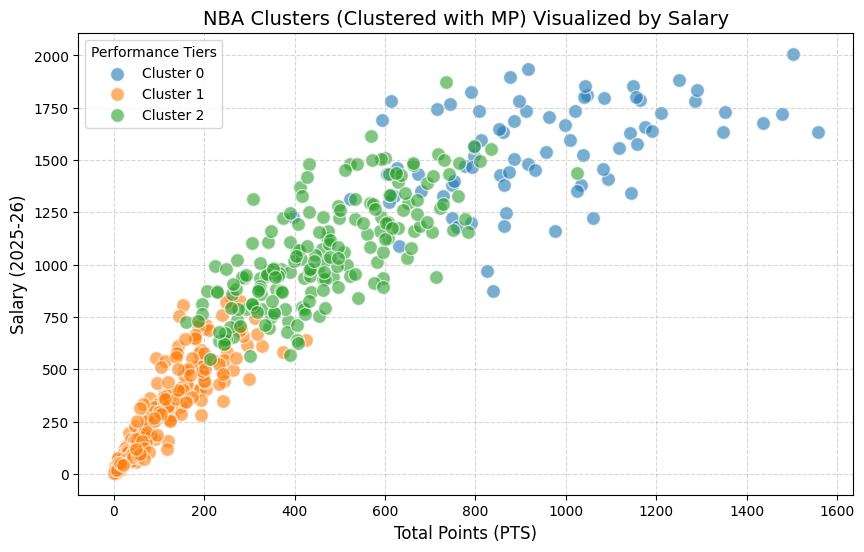

In [ ]:
#Create a visualization of the results with 2 or 3 variables that you think will best
#differentiate the clusters

features = ['2025-26', 'PTS', 'MP', 'TRB', 'AST']
X = clustering[features]

# This ensures that each of the numerical features I selected in the features list above
# are weighted equally in the model.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Running of the kmeans model
kmeans = KMeans(n_clusters = 3, random_state = 42, n_init = 10)
clustering['Cluster'] = kmeans.fit_predict(X_scaled)

# creation of the figure and plotting each cluster with a different color
plt.figure(figsize = (10, 6))

# The variables that I chose based on their potential to differentiate the clusters are
# points ('PTS') and minutes played ('MP').
for cluster_id in sorted(clustering['Cluster'].unique()):
    subset = clustering[clustering['Cluster'] == cluster_id]
    plt.scatter(
        subset['PTS'], 
        subset['MP'], 
        label = f'Cluster {cluster_id}',
        alpha = 0.6,
        edgecolors = 'w',
        s = 100
        )
    
plt.xlabel('Total Points (PTS)', fontsize = 12)
plt.ylabel('Salary (2025-26)', fontsize = 12)
plt.title(f'NBA Clusters (Clustered with MP) Visualized by Salary', fontsize = 14)
plt.legend(title = 'Performance Tiers')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.show()

In [66]:
#Evaluate the quality of the clustering using total variance explained and silhouette scores
# Finding total variance, which is inertia with 1 cluster
model_1 = KMeans(n_clusters = 1, random_state = 42, n_init = 10).fit(X_scaled)
total_inertia = model_1.inertia_

# 3-cluster inertia (3-cluster because I chose a value of 3 for K)
cluster3 = kmeans.inertia_

# Calculation of total variance explained
varexp = (1 - (cluster3 / total_inertia)) * 100
print(f'Total Variance: {varexp}')

# calculation of silhouette scores using sklearn
score = silhouette_score(X_scaled, clustering['Cluster'])
print(f'Silhouette Score: {score}')

Total Variance: 64.24077661321452
Silhouette Score: 0.4003026529959364


In [67]:
#Determine the ideal number of clusters using the elbow method and the silhouette coefficient

# Prediction of the best k value through the elbow method
sse = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    model = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    labels = model.fit_predict(X_scaled)
    # This is for the elbow method
    sse.append(model.inertia_)
    # This is for the Silhouette Coefficient 
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

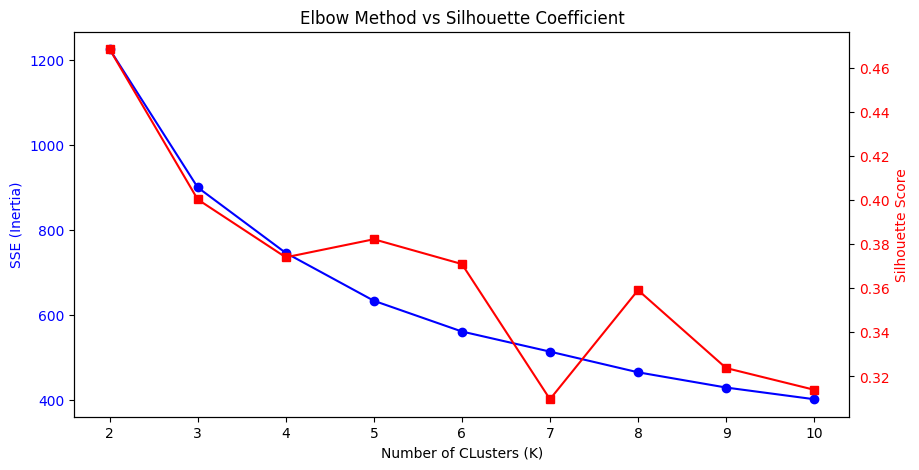

In [68]:
#Visualize the results of the elbow method

# Making the elbow plot to find the best k value
fig, ax1 = plt.subplots(figsize = (10, 5))
ax1.set_xlabel('Number of CLusters (K)')
ax1.set_ylabel('SSE (Inertia)', color = 'blue')
ax1.plot(k_range, sse, marker = 'o', color = 'blue', label = 'SSE')
ax1.tick_params(axis = 'y', labelcolor = 'blue')

# y-axis for the Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color = 'red')
ax2.plot(k_range, sil_scores, marker = 's', color = 'red', label = 'Silhouette Score')
ax2.tick_params(axis = 'y', labelcolor = 'red')

plt.title('Elbow Method vs Silhouette Coefficient')
plt.show()

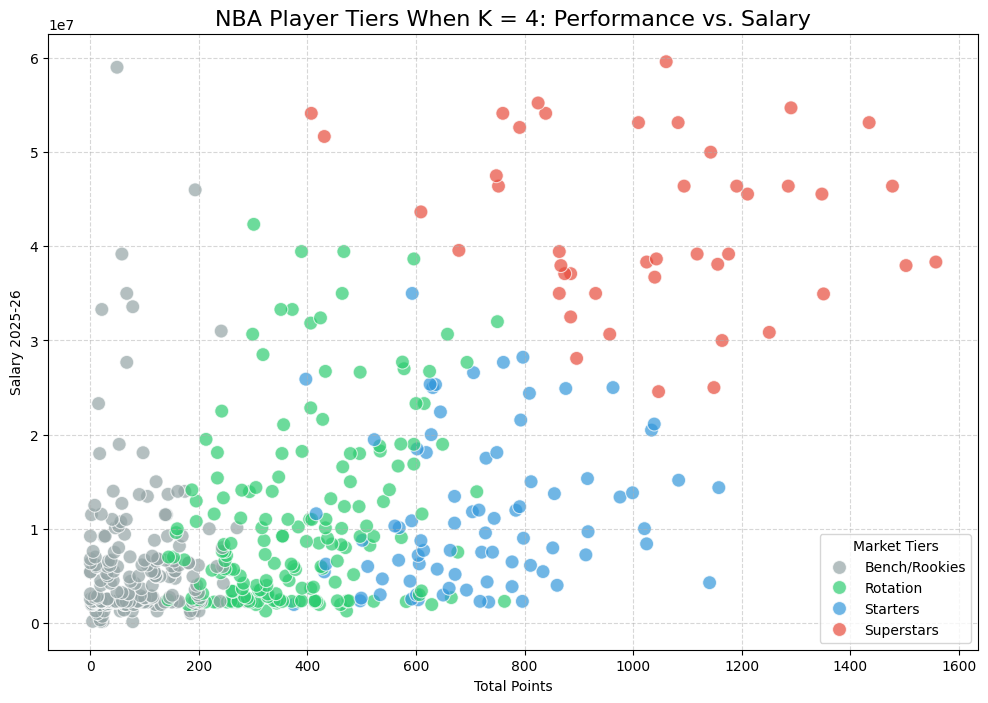

In [ ]:
#Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results
# My elbow plot results proved that the recommended number of clusters is 4 instead of the 3 that I predicted.

kmeans4 = KMeans(n_clusters = 4, random_state = 42, n_init = 10)
# Adding a tier column allows for categorical classification of salaries.
clustering['Tier'] = kmeans4.fit_predict(X_scaled)

# Mapping of tier values to more descriptive names based on salary for easier visualization
tier_map = clustering.groupby('Tier')['2025-26'].mean().sort_values(ascending = False).index
# I determined the boundaries between each of these tier clusters by finding the
# centroids of each cluster through the KMeans Model.
tier_labels = {
    tier_map[0]: 'Superstars', 
    tier_map[1]: 'Starters',
    tier_map[2]: 'Rotation',
    tier_map[3]: 'Bench/Rookies'
    }

clustering['Tier_Name'] = clustering['Tier'].map(tier_labels)

# Visualization of results through a scatterplot
plt.figure(figsize = (12, 8))
palette = {'Superstars': '#e74c3c', 
           'Starters': '#3498db', 
           'Rotation': '#2ecc71',
           'Bench/Rookies': '#95a5a6'}

sns.scatterplot(data = clustering, x = 'PTS', y = '2025-26',
                hue = 'Tier_Name', palette = palette, s = 100, alpha = 0.7)

plt.title('NBA Player Tiers When K = 4: Performance vs. Salary', fontsize = 16)
plt.xlabel('Total Points')
plt.ylabel('Salary 2025-26')
plt.legend(title = 'Market Tiers')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.show()

In [71]:
#Once again evaluate the quality of the clustering using total variance explained and silhouette scores
# I used almost the same code as I did to evaluate the clustering the first time, but with my kmeans4 model.
# Finding total variance, which is inertia with 1 cluster
model_1 = KMeans(n_clusters = 1, random_state = 42, n_init = 10).fit(X_scaled)
total_inertia = model_1.inertia_

# 3-cluster inertia (3-cluster because I chose a value of 3 for K)
cluster3 = kmeans4.inertia_

# Calculation of total variance explained
varexp = (1 - (cluster3 / total_inertia)) * 100
print(f'Total Variance: {varexp}')

# calculation of silhouette scores using sklearn
score = silhouette_score(X_scaled, clustering['Cluster'])
print(f'Silhouette Score: {score}')

Total Variance: 70.36285312976656
Silhouette Score: 0.4003026529959364


In [73]:
#Use the model to select players for Mr. Rooney to consider
# Mr. Rooney should consider players accepting smaller salaries but scoring the same 
# amount of points as a Superstar-classified player. Essentially, he should be looking for
# 'hidden stars'. Therefore, I found good choices by looking through the Rotation and Bench
# clusters and the corresponding names for each data point.
good_choice = clustering[clustering['Tier_Name'].isin(['Rotation', 'Bench/Rookies'])].sort_values('PTS', ascending = False)
print('Good Choices:')
print(good_choice[['Player', 'PTS', '2025-26', 'Tier_Name']].head(4))

# finding the not good choices in the superstar cluster
not_good = clustering[clustering['Tier_Name'] == 'Superstars'].sort_values('PTS', ascending = True)
print('Not Good Choices:')
print(not_good[['Player', 'PTS', '2025-26', 'Tier_Name']].head(4))

Good Choices:
               Player    PTS     2025-26 Tier_Name
76   Tim Hardaway Jr.  763.0   2296274.0  Rotation
458      Jerami Grant  750.0  32000001.0  Rotation
374     Austin Reaves  712.0  13937574.0  Rotation
445   Anfernee Simons  694.0  27678571.0  Rotation
Not Good Choices:
            Player    PTS     2025-26   Tier_Name
508  Anthony Davis  407.0  54126450.0  Superstars
501    Paul George  431.0  51666090.0  Superstars
489  Deandre Ayton  609.0  43654814.0  Superstars
487     OG Anunoby  679.0  39568966.0  Superstars


In [ ]:
#Write up the results in a separate notebook with supporting visualizations and 
# an overview of how and why you made the choices you did. This should be at least 
# 500 words and should be written for a non-technical audience.

# See the file Lab-Clustering-Writeup.ipynb for the writeup.